# Projet 4 : Segmentez des clients d'un site e-commerce
Brazilian E-Commerce Public Dataset by Olist
Le jeu de données comporte 100k commandes de 2016 à 2018 chez plusieurs enseignes au Brésil. Les données renseignent les informations suivantes : prix, évaluation, nombre d'articles, poids, description, géolocalisation...

Objectifs :
Comprendre les différents types d'utilisateurs grâce à leur comportement et à leurs données personnelles

Fournir à Olist, une segmentation de ses clients avec une description actionable de cette segmantation et sa logique sous-jacente

Fournir à Olist, une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps

Pour plus d'informations sur les données : https://www.kaggle.com/olistbr/brazilian-ecommerce

Segmentation RFM :
RFM est un acronyme pour Recence, Fréquence et Montant.

Récence indique la date du dernier achat. Il s'agit du nombre de jours depuis la dernière commande d'un client.
Fréquence est le nombre d'achat sur une période déterminé. Cela peut être 3 mois, 6 mois ou un 1 an. Elle indique la fidélité d'un client, plus sa valeur est élevé et plus le client est engagé.

# from urllib import request
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot, transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from matplotlib.patches import Polygon
import IPython.display
sns.set()

In [1]:
from datetime import timedelta, datetime, tzinfo, timezone
from urllib import request
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot, transforms
import seaborn as sns
import numpy as np
import re
from matplotlib.patches import Polygon
import IPython.display
import warnings
warnings.filterwarnings('ignore')
sns.set()

In [2]:
file_path = '/Users/admin/Desktop/formation_data_Scientist/projet5/Donnees/'

In [62]:
customers = pd.read_csv(file_path + 'olist_customers_dataset.csv')
geolocation = pd.read_csv(file_path + 'olist_geolocation_dataset.csv')
order_items = pd.read_csv(file_path + 'olist_order_items_dataset.csv')
order_payments = pd.read_csv(file_path + 'olist_order_payments_dataset.csv')
order_reviews = pd.read_csv(file_path + 'olist_order_reviews_dataset.csv')
orders = pd.read_csv(file_path + 'olist_orders_dataset.csv')
products = pd.read_csv(file_path + 'olist_products_dataset.csv')
sellers = pd.read_csv(file_path + 'olist_sellers_dataset.csv')
category_name_translation = pd.read_csv(file_path + 'product_category_name_translation.csv')


In [63]:
orders.shape

(99441, 8)

In [64]:
#pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500) 
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 300000)


In [65]:
orders.isna().sum(axis = 0).sum()/len(orders)/len(orders.columns)*100

0.616948743476031

## 2: Informations les jeux de données initial

### 2. 1: Informations les datasets

In [66]:
list(orders.columns)

['order_id',
 'customer_id',
 'order_status',
 'order_purchase_timestamp',
 'order_approved_at',
 'order_delivered_carrier_date',
 'order_delivered_customer_date',
 'order_estimated_delivery_date']

In [67]:
mydict = {'customers' : customers, 
         'geolocation' : geolocation,
           'order_items' : order_items,
           'order_payments' : order_payments,
           'order_reviews': order_reviews,
           'orders' : orders,
           'products' :products,
           'sellers' : sellers,
           'category_name_translation' : category_name_translation}

In [68]:
def datatsets_info(mydict):
    df_info = pd.DataFrame({})  
    list_col_with_NaN = []  
    for cle, value in mydict.items():
        df_info.loc[cle, 'df'] = cle
        df_info.loc[cle, 'nombre de lignes'] = (value.shape[0])
        df_info.loc[cle,'nombre columns'] = value.shape[1]  
        df_info.loc[cle,'% Columns Name'] =   ' ,'.join(list(value.columns))
        df_info.loc[cle, 'duplicated'] = value.duplicated().sum()
        df_info.loc[cle,'% NaN'] = value.isna().sum(axis = 0).sum()/len(value)/len(value.columns)*100
        for col in value.columns:
            if value[col].isna().sum()!=0:
                list_col_with_NaN.append(col)
                df_info.loc[cle,'Name Columns with NaN'] =' ,'.join((list(list_col_with_NaN)))
            
        list_col_with_NaN = []
    df_info = df_info.reset_index().drop('index', axis = 1)
    df_info = df_info.style.background_gradient(cmap='Blues')
    return df_info
datatsets_info(mydict)

,df,nombre de lignes,nombre columns,% Columns Name,duplicated,% NaN,Name Columns with NaN
0,customers,99441.000000,5.000000,"customer_id ,customer_unique_id ,customer_zip_code_prefix ,customer_city ,customer_state",0.000000,0.000000,nan
1,geolocation,1000163.000000,5.000000,"geolocation_zip_code_prefix ,geolocation_lat ,geolocation_lng ,geolocation_city ,geolocation_state",261831.000000,0.000000,nan
2,order_items,112650.000000,7.000000,"order_id ,order_item_id ,product_id ,seller_id ,shipping_limit_date ,price ,freight_value",0.000000,0.000000,nan
3,order_payments,103886.000000,5.000000,"order_id ,payment_sequential ,payment_type ,payment_installments ,payment_value",0.000000,0.000000,nan
4,order_reviews,99224.000000,7.000000,"review_id ,order_id ,review_score ,review_comment_title ,review_comment_message ,review_creation_date ,review_answer_timestamp",0.000000,21.006295,"review_comment_title ,review_comment_message"
5,orders,99441.000000,8.000000,"order_id ,customer_id ,order_status ,order_purchase_timestamp ,order_approved_at ,order_delivered_carrier_date ,order_delivered_customer_date ,order_estimated_delivery_date",0.000000,0.616949,"order_approved_at ,order_delivered_carrier_date ,order_delivered_customer_date"
6,products,32951.000000,9.000000,"product_id ,product_category_name ,product_name_lenght ,product_description_lenght ,product_photos_qty ,product_weight_g ,product_length_cm ,product_height_cm ,product_width_cm",0.000000,0.825468,"product_category_name ,product_name_lenght ,product_description_lenght ,product_photos_qty ,product_weight_g ,product_length_cm ,product_height_cm ,product_width_cm"
7,sellers,3095.000000,4.000000,"seller_id ,seller_zip_code_prefix ,seller_city ,seller_state",0.000000,0.000000,nan
8,category_name_translation,71.000000,2.000000,"product_category_name ,product_category_name_english",0.000000,0.000000,nan


### 2.2: Informations sur les colonnes

In [69]:
def datasets_cols_info(mydict):
    df = []
    colonnes = []
    types = []
    liste_unique = []
    liste_indices = []
    len_df = []
    missing_data = []
    numb_duplicated = []
    for cle, value in mydict.items():
    #liste_indices.append(i)
        for col in value.columns:
            df.append(cle)
            colonnes.append(col)
            types.append(value[col].dtype)
            liste_unique.append(value[col].nunique())
            numb_duplicated.append(value[col].duplicated().sum())
            len_df.append(len(value[col]))
            missing_data.append(value[col].isna().sum()/len(value[col])*100)
        
    df_cols_info = pd.DataFrame([df, colonnes, types, liste_unique, numb_duplicated, missing_data, len_df]).T
    df_cols_info.columns = ['df', 'columns', 'types', 'nunique', 'duplicated', 'missing_data', 'len_df']
    df_cols_info = df_cols_info.style.background_gradient(cmap='Blues')
    return df_cols_info
datasets_cols_info(mydict)

,df,columns,types,nunique,duplicated,missing_data,len_df
0,customers,customer_id,object,99441,0,0.000000,99441
1,customers,customer_unique_id,object,96096,3345,0.000000,99441
2,customers,customer_zip_code_prefix,int64,14994,84447,0.000000,99441
3,customers,customer_city,object,4119,95322,0.000000,99441
4,customers,customer_state,object,27,99414,0.000000,99441
5,geolocation,geolocation_zip_code_prefix,int64,19015,981148,0.000000,1000163
6,geolocation,geolocation_lat,float64,717360,282803,0.000000,1000163
7,geolocation,geolocation_lng,float64,717613,282550,0.000000,1000163
8,geolocation,geolocation_city,object,8011,992152,0.000000,1000163
9,geolocation,geolocation_state,object,27,1000136,0.000000,1000163


## 3: Nettoyage et concaténation

### 3. 1 Nettoyage  types

In [70]:
order_items['shipping_limit_date'] = order_items['shipping_limit_date'].astype('datetime64')
orders['order_purchase_timestamp'] = orders['order_purchase_timestamp'].astype('datetime64')
order_reviews['review_answer_timestamp'] = order_reviews['review_answer_timestamp'].astype('datetime64')
orders['order_approved_at'] = pd.to_datetime(orders['order_approved_at'], errors='coerce')
orders['order_delivered_carrier_date'] = pd.to_datetime(
orders['order_delivered_carrier_date'], errors='coerce')
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'], errors='coerce')
        
orders['order_estimated_delivery_date'] = orders['order_estimated_delivery_date'].astype('datetime64')

In [71]:
type(pd.DataFrame())

pandas.core.frame.DataFrame

In [72]:
customers

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP
...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS


In [73]:
products['product_id'].dtype

dtype('O')

In [74]:
order_reviews

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
...,...,...,...,...,...,...,...
99219,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5,NaN,NaN,2018-07-07 00:00:00,2018-07-14 17:18:30
99220,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09 00:00:00,2017-12-11 20:06:42
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43
99222,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01 00:00:00,2018-07-02 12:59:13


### 3.2 Concaténations des datasets

Les datatsets présentés précédemment sont liés les uns aux autres par des variables communes permettant de faire des jointures
Les différentes variables de liaison sont en forme d'un id commun entre deux datasets ou plus. La figure ci dessous montre un
les variables de liaison entre les différentes datasets

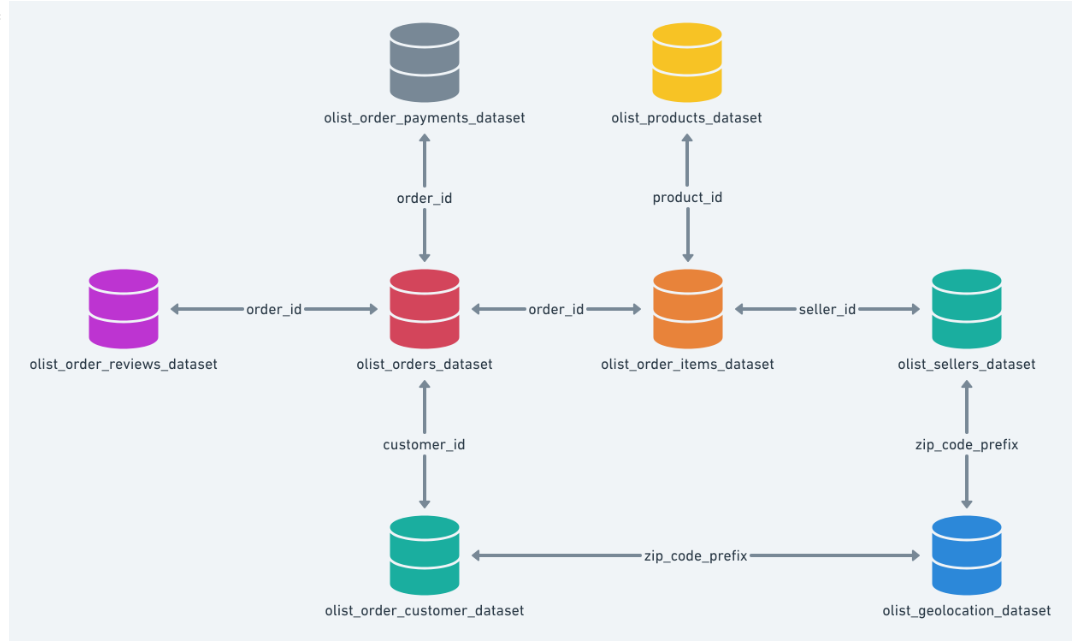

In [75]:
customers_to_concat = customers.copy()
geolocation_to_concat = geolocation.copy()
order_items_to_concat = order_items.copy()
order_payments_to_concat = order_payments.copy()
order_reviews_to_concat = order_reviews.copy()
orders_to_concat = orders.copy()
products_to_concat = products.copy()
sellers_to_concat = sellers.copy()
category_name_translation_to_concat = category_name_translation.copy()

In [76]:
customers_to_concat

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP
...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS


#### 3.2.1 merge des datasets products et category_name_translation

In [77]:
products = pd.merge(products_to_concat, category_name_translation_to_concat,
                    how="left",
                    on="product_category_name")

In [78]:
dict_categories = {
#home
'furniture_living_room' : 'home',
'furniture_mattress_and_upholstery' : 'home',
'furniture_bedroom' : 'home',
'furniture_decor' : 'home',
'bed_bath_table' : 'home',
'kitchen_dining_laundry_garden_furniture' : 'home',
'la_cuisine' : 'home',
'home_confort' : 'home',
'home_comfort_2' : 'home',
'christmas_supplies' : 'home',
    
#appliances
'small_appliances' : 'appliances',
'small_appliances_home_oven_and_coffee' : 'appliances',
'home_appliances_2' : 'appliances',
'home_appliances' : 'appliances',
'housewares' : 'appliances',
    
#construction
'construction_tools_construction': 'construction',
'costruction_tools_garden': 'construction',
'costruction_tools_tools': 'construction',
'construction_tools_safety': 'construction',
'construction_tools_lights': 'construction',
'home_construction': 'construction',
'air_conditioning': 'construction',
    
#office
'office_furniture' : 'office',
'industry_commerce_and_business' : 'office',
'stationery' : 'office',
'agro_industry_and_commerce' : 'office',
'signaling_and_security' : 'office',
'furnitures' : 'office',
'security_and_services' : 'office',
#electronics
'telephony' : 'electronics',
'electronics': 'electronics',
'computers_accessories': 'electronics',
'consoles_games': 'electronics',
'fixed_telephony': 'electronics',
'audio': 'electronics',
'computers': 'electronics',
'tablets_printing_image': 'electronics',
#sports_leisure
'sports_leisure' : 'sports_leisure',
'musical_instruments': 'sports_leisure',
'party_supplies': 'sports_leisure',
'luggage_accessories': 'sports_leisure',
#arts
'books' : 'arts',
'books_imported': 'arts',
'books_general_interest': 'arts',
'books_technical': 'arts',
'art': 'arts',
'toys': 'arts',
'cine_photo': 'arts',
'cds_dvds_musicals': 'arts',
'music': 'arts',
'dvds_blu_ray': 'arts',
'arts_and_craftmanship': 'arts',
#fashion
'watches_gifts' : 'fashion',
'fashion_bags_accessories' : 'fashion',
'fashion_underwear_beach' : 'fashion',
'fashion_shoes' : 'fashion', 
'fashion_male_clothing' : 'fashion',
'fashio_female_clothing' : 'fashion',
'fashion_sport' : 'fashion',
'fashion_childrens_clothes' : 'fashion',
#health_beauty
'health_beauty' : 'health_beauty', 
'baby': 'health_beauty',
'diapers_and_hygiene' : 'health_beauty',
'perfumery' : 'health_beauty',
#garden and pets
'flowers' : 'garden_pets',
'pet_shop' : 'garden_pets',
'garden_tools' : 'garden_pets',
#auto
'auto' : 'auto',
#food_drinks
'food_drink' : 'food_drinks',
'food' : 'food_drinks',
'drinks' : 'food_drinks',
#other
'Unknown' : 'other',
'market_place' : 'other', 
'cool_stuff' : 'other'}

In [79]:
products

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,art
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0,sports_leisure
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0,baby
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0,housewares
...,...,...,...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,45.0,67.0,2.0,12300.0,40.0,40.0,40.0,furniture_decor
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,41.0,971.0,1.0,1700.0,16.0,19.0,16.0,construction_tools_lights
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,50.0,799.0,1.0,1400.0,27.0,7.0,27.0,bed_bath_table
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,60.0,156.0,2.0,700.0,31.0,13.0,20.0,computers_accessories


In [80]:
products['product_category_name_english'] = products['product_category_name_english'].replace(dict_categories)

In [81]:
list_to_drop = ['product_category_name_english_x', 'product_category_name_english_y', 'product_category_name']

In [82]:
#products.drop(list_to_drop, axis = 1,
             #inplace = True)

In [83]:
products.rename({'product_category_name_english':'Categ_les_plus_acheté'}, axis = 1, inplace = True)

#### 3.2.2:  merge de order_items et orders

### le nombre de ligne du datatset orders est égal au nombre unique de order_id

In [84]:
order_items_to_concat

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


#### 3.2.2:   merge des datatsets  order_items et order_payments

In [85]:
order_payments_to_concat['payment_type'].value_counts()

credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: payment_type, dtype: int64

- remplacement de l'observation 'not defined' par le moyen de payement le plus occurrent
- transformation des observation de type de payements en des variables de types booléennes
- aggrégation by 'order id' avec
{"payment_sequential": 'max',
     "payment_installments": 'sum','payment_value': 'mean', 'voucher': 'sum', 'credit_card': 'sum', 
     'boleto': 'sum', 'debit_card': 'sum'})


In [86]:
order_payments_to_concat['payment_type'] = order_payments_to_concat['payment_type'].replace({'not_defined': 'credit_card'})
order_payments_to_concat['credit_card'] = order_payments_to_concat['payment_type']
order_payments_to_concat['boleto'] = order_payments_to_concat['payment_type']
order_payments_to_concat['debit_card'] = order_payments_to_concat['payment_type']
order_payments_to_concat['voucher'] = order_payments_to_concat['payment_type']

order_payments_to_concat['credit_card'] = order_payments_to_concat['credit_card'].\
replace({'credit_card': 1, 'boleto': 0, 'voucher': 0, 'debit_card':0})
order_payments_to_concat['boleto'] = order_payments_to_concat['boleto'].\
replace({'credit_card': 0, 'boleto': 1, 'voucher': 0, 'debit_card':0})
order_payments_to_concat['voucher'] = order_payments_to_concat['boleto'].\
replace({'credit_card': 1, 'boleto': 0, 'voucher': 1, 'debit_card':0})
order_payments_to_concat['debit_card'] = order_payments_to_concat['boleto'].\
replace({'credit_card':0, 'boleto': 0, 'voucher': 0, 'debit_card':1})


In [87]:
order_payments_to_concat[['credit_card', 'boleto', 'debit_card']] = order_payments_to_concat[['credit_card', 'boleto', 'debit_card']].astype('int64')

In [88]:
group_payments_to_concat = order_payments_to_concat.groupby(by="order_id").agg(
    {"payment_sequential": 'max',
     "payment_installments": 'sum','payment_value': 'mean', 'voucher': 'sum', 'credit_card': 'sum', 
     'boleto': 'sum', 'debit_card': 'sum'})

In [89]:
orders_to_concat = pd.merge(orders_to_concat, group_payments_to_concat,
                       how="left",
                       on="order_id") 

In [90]:
order_items_to_concat = pd.merge(order_items_to_concat, orders_to_concat,
                       how="left",
                       on="order_id")

#### 3.2.3:  merge des datasets  orders_items et orders_review

In [91]:
# Conversion des données dates en datetime
review_answer_timestamp = pd.to_datetime(order_reviews_to_concat["review_answer_timestamp"])
review_creation_date = pd.to_datetime(order_reviews_to_concat["review_creation_date"])
# Délai d'évaluation des produits
review_answer = review_answer_timestamp - review_creation_date
# Converti en secondes
review_answer = review_answer.dt.total_seconds()/(3600*24)
order_reviews_to_concat["Delay_to_answer"] = review_answer

In [92]:
group_reviews = order_reviews_to_concat.groupby("order_id").agg({
    "review_id": "count", 'review_comment_title': 'count', 'review_comment_message': 'count', 'Delay_to_answer': 'mean',
    "review_score": "mean"})

In [93]:
order_items_to_concat = pd.merge(order_items_to_concat, group_reviews,
                       how="left",
                       on="order_id")

#### 3.2.4:  merge de orders_items et customer

In [94]:
order_items_to_concat = pd.merge( order_items_to_concat, customers_to_concat, 
                       how="right",
                       on="customer_id")

#### 3.2.5:  merge des datasets orders_items et de Seller

In [95]:
order_items_to_concat = pd.merge(order_items_to_concat, sellers_to_concat,
                       how="left",
                       on="seller_id")

#### 3.2.6:  merge des datasets orders_items et de Seller

- Supprimer les duplicata sur la variable geolocation_zip_code_prefix
- mettre un noms unique pour les variables qui contiennent 'zip-code_prefix' des deux datatset customer et geolocation

In [96]:
geolocation_to_concat.drop_duplicates(subset=["geolocation_zip_code_prefix"],
                    keep="first", inplace=True)
geolocation_to_concat["customer_zip_code_prefix"] = geolocation_to_concat["geolocation_zip_code_prefix"]
# Fusion des données clients avec les données géographiques
# Fusion des données clients avec les données géographiques
order_items_to_concat = pd.merge(order_items_to_concat, geolocation_to_concat, how='left',
                     on=["customer_zip_code_prefix"])

In [97]:
data = pd.merge(order_items_to_concat, products_to_concat,
               how="left",
               on="product_id")

In [98]:
data["delivery_delta_days"] = (data.order_delivered_customer_date
                               - data.order_purchase_timestamp)\
                              .dt.round('1d').dt.days

In [99]:
data["estimated_delivery_delta_days"] = (data.order_estimated_delivery_date
                               - data.order_purchase_timestamp)\
                              .dt.round('1d').dt.days

In [100]:
data

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_installments,payment_value,voucher,credit_card,boleto,debit_card,review_id,review_comment_title,review_comment_message,Delay_to_answer,review_score,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,delivery_delta_days,estimated_delivery_delta_days
0,00e7ee1b050b8499577073aeb2a297a1,1.0,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,06b8999e2fba1a1fbc88172c00ba8bc7,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,1.0,2.0,146.87,0.0,1.0,0.0,0.0,1.0,0.0,0.0,4.940741,4.0,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,8577.0,itaquaquecetuba,SP,14409.0,-20.509897,-47.397866,franca,SP,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,9.0,19.0
1,29150127e6685892b6eab3eec79f59c7,1.0,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48,18955e83d337fd6b2def6b18a428ac77,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,1.0,8.0,335.48,0.0,1.0,0.0,0.0,1.0,0.0,0.0,11.946863,5.0,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,88303.0,itajai,SC,9790.0,-23.726853,-46.545746,sao bernardo do campo,SP,utilidades_domesticas,43.0,1002.0,3.0,10150.0,89.0,15.0,40.0,17.0,24.0
2,b2059ed67ce144a36e2aa97d2c9e9ad2,1.0,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79,4e7b3e00288586ebd08712fdd0374a03,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,1.0,7.0,157.73,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.507627,5.0,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,8577.0,itaquaquecetuba,SP,1151.0,-23.527788,-46.660310,sao paulo,SP,moveis_escritorio,55.0,955.0,1.0,8267.0,52.0,52.0,17.0,26.0,24.0
3,951670f92359f4fe4a63112aa7306eba,1.0,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36,b2b6027bc5c5109e529d4dc6358b12c3,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,1.0,1.0,173.30,0.0,1.0,0.0,0.0,1.0,0.0,0.0,4.775544,5.0,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,8577.0,itaquaquecetuba,SP,8775.0,-23.496930,-46.185352,mogi das cruzes,SP,moveis_escritorio,48.0,1066.0,1.0,12160.0,56.0,51.0,28.0,15.0,27.0
4,6b7d50bd145f6fc7f33cebabd7e49d0f,1.0,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25,4f2d8ab171c80ec8364f7c12e35b23ad,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,1.0,8.0,252.25,0.0,1.0,0.0,0.0,1.0,1.0,1.0,7.083241,5.0,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,14940.0,ibitinga,SP,13056.0,-22.987222,-47.151073,campinas,SP,casa_conforto,61.0,407.0,1.0,5200.0,45.0,15.0,35.0,11.0,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113420,6760e20addcf0121e9d58f2f1ff14298,1.0,ccb4503d9d43d245d3b295d0544f988b,527801b552d0077ffd170872eb49683b,2018-04-12 16:08:45,74.90,13.88,17ddf5dd5d51696bb3d7c6291687be6f,delivered,2018-04-07 15:48:17,2018-04-07 16:08:45,2018-04-11 02:08:36,2018-04-13 20:06:37,2018-04-25,1.0,6.0,88.78,0.0,1.0,0.0,0.0,1.0,1.0,0.0,14.468796,4.0,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,

In [101]:
#data = data.loc[data['order_purchase_timestamp'] >= today - timedelta(days=365)]

In [102]:
#data['order_purchase_timestamp']

In [103]:
x = data['order_purchase_timestamp'].max() + timedelta(days =1)

In [104]:
x

Timestamp('2018-09-04 09:06:57')

# Création du dataset client

In [105]:
data_customers = data.copy()

In [106]:
data_customers.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'payment_sequential', 'payment_installments', 'payment_value', 'voucher', 'credit_card', 'boleto', 'debit_card', 'review_id', 'review_comment_title', 'review_comment_message', 'Delay_to_answer', 'review_score', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state', 'seller_zip_code_prefix', 'seller_city', 'seller_state', 'geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng', 'geolocation_city', 'geolocation_state', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'delivery_delta_days', 'estimated_delivery_delta_days'], dtype='o

In [112]:
data_customers[['geolocation_city', 'customer_city', 'geolocation_lat', 'geolocation_lng', 'geolocation_city',]]

,geolocation_city,customer_city,geolocation_lat,geolocation_lng,geolocation_city
0,franca,franca,-20.509897,-47.397866,franca
1,sao bernardo do campo,sao bernardo do campo,-23.726853,-46.545746,sao bernardo do campo
2,sao paulo,sao paulo,-23.527788,-46.660310,sao paulo
3,mogi das cruzes,mogi das cruzes,-23.496930,-46.185352,mogi das cruzes
4,campinas,campinas,-22.987222,-47.151073,campinas
...,...,...,...,...,...
113420,são paulo,sao paulo,-23.587901,-46.501830,são paulo
113421,taboao da serra,taboao da serra,-23.612294,-46.765787,taboao da serra
113422,fortaleza,fortaleza,-3.744128,-38.510859,fortaleza
113423,canoas,canoas,-29.956391,-51.167614,canoas


In [113]:
data_customers.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'payment_sequential', 'payment_installments', 'payment_value', 'voucher', 'credit_card', 'boleto', 'debit_card', 'review_id', 'review_comment_title', 'review_comment_message', 'Delay_to_answer', 'review_score', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state', 'seller_zip_code_prefix', 'seller_city', 'seller_state', 'geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng', 'geolocation_city', 'geolocation_state', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'delivery_delta_days', 'estimated_delivery_delta_days'], dtype='o

In [114]:
data_rfm 


NameError: name 'data_rfm' is not defined

## Création de la dataframe RFM 

La méthode descriptive de segmentation RFM est basée sur trois critère: Récence(date de la dernière commande), la Fréquence des commandes et le Montant (de la dernière commande ou sur une période donnée).
Cette approche permet de tenir compte du comportement d'achat des clients ainsi que de leur potentiel.


In [ ]:
date_segmentation

In [115]:
date_segmentation = data['order_purchase_timestamp'].max() + timedelta(days =1)

In [116]:
def data_RFM(df, days):
    date_segmentation = df['order_purchase_timestamp'].max() + timedelta(days =days)
    print('le date choisie pour  la segmntation est:', date_segmentation)
    data_customers = df.copy()
    #Calcul de la Récence
    data_customers['delay_last_order'] = data_customers['order_purchase_timestamp'].apply(
        lambda x: (date_segmentation - x).days)
    #Calcul du montant moyenne et de la Fréquence 
    data_rfm = data_customers.groupby("customer_unique_id")\
            .agg({"price": "mean", 'order_purchase_timestamp': lambda x:
                    len([d for d in x]), 'delay_last_order': 'min' #va
            })
    data_rfm = data_rfm.rename({'price': 'price_mean', 
                                'order_purchase_timestamp': 'frequency', 
                                'delay_last_order': 'recency'}, axis = 1)
    return data_rfm
data_rfm = data_RFM(df = data, days = 1)

le date choisie pour  la segmntation est: 2018-09-04 09:06:57


In [ ]:
data_rfm = data_rfm.reset_index

### Analyse Exploratoire de la RFM 

In [117]:
data_rfm  = data_rfm.reset_index()

In [118]:
data_rfm

,customer_unique_id,price_mean,frequency,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90,1,116.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90,1,119.0
2,0000f46a3911fa3c0805444483337064,69.00,1,542.0
3,0000f6ccb0745a6a4b88665a16c9f078,25.99,1,326.0
4,0004aac84e0df4da2b147fca70cf8255,180.00,1,293.0
...,...,...,...,...
96091,fffcf5a5ff07b0908bd4e2dbc735a684,785.00,2,452.0
96092,fffea47cd6d3cc0a88bd621562a9d061,64.89,1,267.0
96093,ffff371b4d645b6ecea244b27531430a,89.90,1,573.0
96094,ffff5962728ec6157033ef9805bacc48,115.00,1,124.0


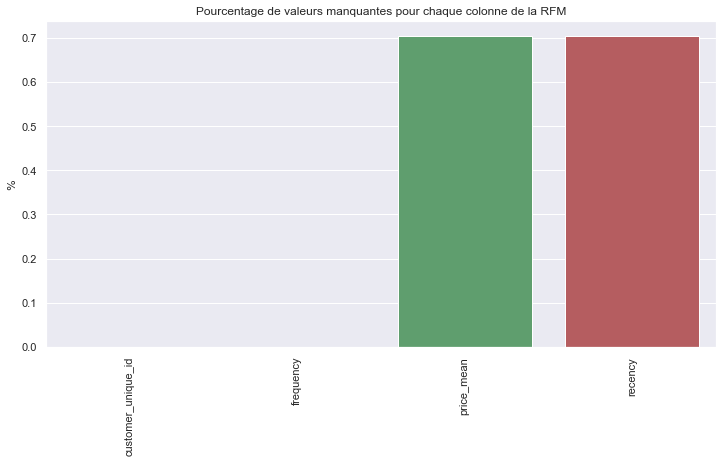

In [119]:
def missing_data(df):
    pourcentage_of_NaN = df.isna().sum(axis=0).sort_values()/len(df)*100

    # Affiche la proportion de données manquants par colonne
    fig = plt.figure(figsize=(12, 6))
    sns.barplot(x=pourcentage_of_NaN.index, y=pourcentage_of_NaN.values)
    plt.ylabel("%")
    plt.title("Pourcentage de valeurs manquantes pour chaque colonne de la RFM")
    plt.style.use('ggplot')
    plt.xticks(rotation=90)
    plt.show()
    return plt.show()
missing_data(df = data_rfm )

### Analyse Univariée

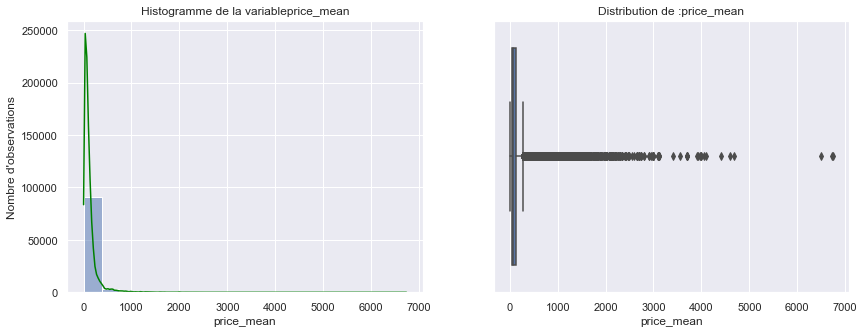

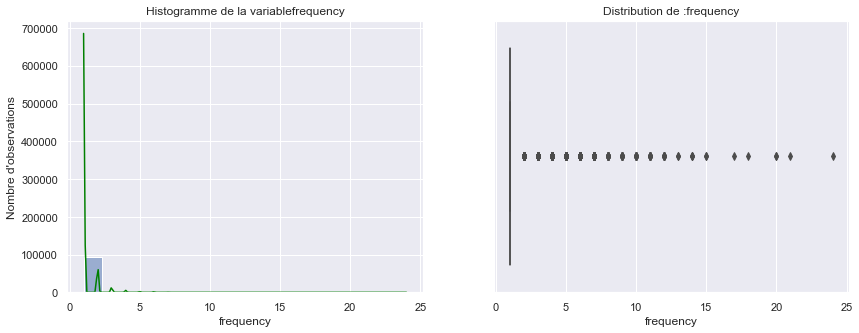

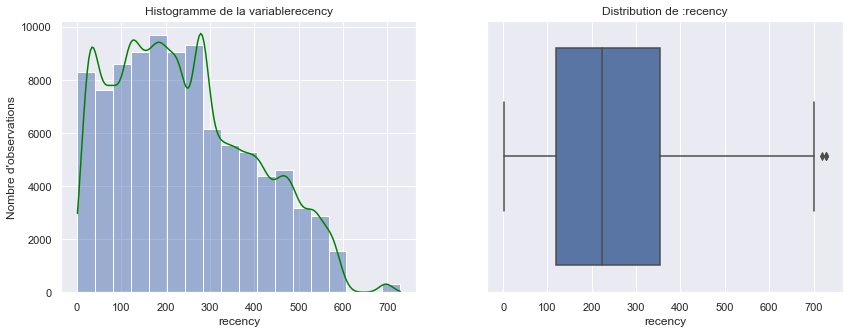

In [85]:
for col in data_rfm.drop(columns='customer_unique_id').columns.tolist():
        fig = plt.figure(figsize = (14, 5))
        gs = fig.add_gridspec(1,2)
        ax = fig.add_subplot(gs[0,0])
        ax1 = fig.add_subplot(gs[0,1])
        #ax1 = Histogramme
        #sns.kdeplot(df[col], ax = ax)
        sns.histplot(data_rfm[col], ax = ax,  bins="sturges",  kde = True)
        ax.lines[0].set_color('green')
        ax.set_xlabel(col)
        ax.set_ylabel("Nombre d'observations")
        ax.set_title('Histogramme de la variable'+ col )
        #ax1: Boite à Maustache
        sns.boxplot(data_rfm[col])
        ax1.set_xlabel(col)
        ax1.set_title('Distribution de :' + col )
        plt.show()

### Analyse Bivariée

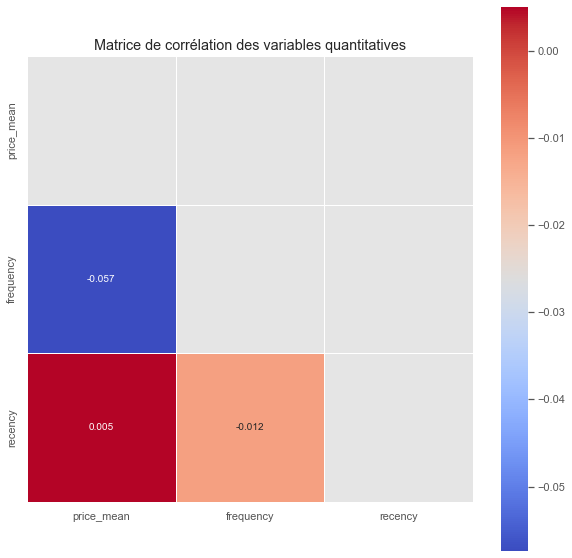

In [125]:
corr_matrix = data_rfm.select_dtypes(include = ['int', 'float']).corr()
mask = np.triu(corr_matrix)
plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix, cmap="coolwarm", mask=mask, linewidths=.5, annot=True, cbar=True, square=True)
plt.title("Matrice de corrélation des variables quantitatives")
#plt.savefig("Présentation/Images/matrice_corr.png")
plt.show()

In [76]:
data_customers

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_installments,payment_value,voucher,credit_card,boleto,debit_card,review_id,review_comment_title,review_comment_message,Delay_to_answer,review_score,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,delivery_delta_days,estimated_delivery_delta_days,delay_last_order
0,00e7ee1b050b8499577073aeb2a297a1,1.0,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,06b8999e2fba1a1fbc88172c00ba8bc7,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,1.0,2.0,146.87,0.0,1.0,0.0,0.0,1.0,0.0,0.0,4.940741,4.0,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,8577.0,itaquaquecetuba,SP,14409.0,-20.509897,-47.397866,franca,SP,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,9.0,19.0,475.0
1,29150127e6685892b6eab3eec79f59c7,1.0,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48,18955e83d337fd6b2def6b18a428ac77,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,1.0,8.0,335.48,0.0,1.0,0.0,0.0,1.0,0.0,0.0,11.946863,5.0,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,88303.0,itajai,SC,9790.0,-23.726853,-46.545746,sao bernardo do campo,SP,utilidades_domesticas,43.0,1002.0,3.0,10150.0,89.0,15.0,40.0,17.0,24.0,234.0
2,b2059ed67ce144a36e2aa97d2c9e9ad2,1.0,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79,4e7b3e00288586ebd08712fdd0374a03,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,1.0,7.0,157.73,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.507627,5.0,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,8577.0,itaquaquecetuba,SP,1151.0,-23.527788,-46.660310,sao paulo,SP,moveis_escritorio,55.0,955.0,1.0,8267.0,52.0,52.0,17.0,26.0,24.0,107.0
3,951670f92359f4fe4a63112aa7306eba,1.0,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36,b2b6027bc5c5109e529d4dc6358b12c3,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,1.0,1.0,173.30,0.0,1.0,0.0,0.0,1.0,0.0,0.0,4.775544,5.0,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,8577.0,itaquaquecetuba,SP,8775.0,-23.496930,-46.185352,mogi das cruzes,SP,moveis_escritorio,48.0,1066.0,1.0,12160.0,56.0,51.0,28.0,15.0,27.0,174.0
4,6b7d50bd145f6fc7f33cebabd7e49d0f,1.0,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25,4f2d8ab171c80ec8364f7c12e35b23ad,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,1.0,8.0,252.25,0.0,1.0,0.0,0.0,1.0,1.0,1.0,7.083241,5.0,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,14940.0,ibitinga,SP,13056.0,-22.987222,-47.151073,campinas,SP,casa_conforto,61.0,407.0,1.0,5200.0,45.0,15.0,35.0,11.0,17.0,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113420,6760e20addcf0121e9d58f2f1ff14298,1.0,ccb4503d9d43d245d3b295d0544f988b,527801b552d0077ffd170872eb49683b,2018-04-12 16:08:45,74.90,13.88,17ddf5dd5d51696bb3d7c6291687be6f,delivered,2018-04-07 15:48:17,2018-04-07 16:08:45,2018-04-11 02:08:36,2018-04-13 20:06:37,2018-04-25,1.0,6.0,88.78,0.0,1.0,0.0,0.0,1.0,1.0,0.0,14.468796,4.

## Segmentation de la RFM

In [128]:
def r_score(x, quintiles):
    """
    Attribut une note entre 1 et 5 suivant l'emplacement de x par
    rapport aux quintiles. Plus la 'Recency' est faible, plus la note
    est élevé
    x(float): valeur
    quintiles(dict): voir fonction calculQuantile
    """

    if x <= quintiles['recency'][.2]:
        return 5
    elif x <= quintiles['recency'][.4]:
        return 4
    elif x <= quintiles['recency'][.6]:
        return 3
    elif x <= quintiles['recency'][.8]:
        return 2
    else:
        return 1


def fm_score(x, quintiles, c):
    """
    Attribut une note entre 1 et 5 suivant l'emplacement de x par
    rapport aux quintiles. Plus x est grand, plus la note est grande
    x(float): valeur
    quintiles(dict): voir fonction calculQuantile
    """

    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5


def calculate_quantile(rfm):
    """
    Calcul des quantiles pour chaque variable Recency, Frequency et Monetary
    puis attribut un score (fm_score et r_score) suivant la valeur
    des variables de chaque individu
    rfm(pd.DataFrame): présente les colonnes 'Recency', 'Frequency' et Monetary
    """
    quintiles = rfm[['recency',
                     'frequency',
                     'price_mean']].quantile([.2, .4, .6, .8, 0.995]).to_dict()

    rfm['R'] = rfm['recency'].apply(lambda x:
                                    r_score(x, quintiles))
    rfm['F'] = rfm['frequency'].apply(lambda x:
                                      fm_score(x, quintiles, 'frequency'))
    rfm['M'] = rfm['price_mean'].apply(lambda x:
                                     fm_score(x, quintiles, 'price_mean'))
    Labels_score_recency = ['R-', 'R', 'R+']
    Labels_score_frequency = ['F-', 'F', 'F+']
    Labels_score_Montery = ['M-', 'M', 'M+']
    rfm['total_score'] = rfm[['R', 'F', 'M']].sum(axis = 1)
    #score_cuts = pd.cut(rfm['R'], bins = [0,1,2,3,4,5], labels = L)
    score_cuts_receny = pd.cut(rfm['R'], bins = [0,2,4,5], labels = Labels_score_recency)
    score_cuts_frequency = pd.cut(rfm['F'], bins = [0,2,4,5], labels = Labels_score_frequency)
    score_cuts__Montery = pd.cut(rfm['M'], bins = [0,2,4,5], labels = Labels_score_Montery)
    rfm['labels_score_recency'] = score_cuts_receny.values
    rfm['Labels_score_frequency'] = score_cuts_frequency.values
    rfm['Labels_score_Montery'] = score_cuts__Montery.values
    rfm[['Labels_score_Montery', 'Labels_score_frequency', 'labels_score_recency']] =rfm[['Labels_score_Montery', 'Labels_score_frequency', 'labels_score_recency']].astype('object')
    
    rfm['Group_label'] = rfm['labels_score_recency'] + rfm['Labels_score_frequency']\
    + rfm['Labels_score_Montery']
    
    print()
    return rfm
rfm_table_3 = calculate_quantile(data_rfm)

In [88]:
print(rfm_table_3['labels_score_recency'] + rfm_table_3['labels_score_recency'])

0          RR
1          RR
2        R-R-
3        R-R-
4        R-R-
         ... 
96091    R-R-
96092      RR
96093    R-R-
96094      RR
96095    R-R-
Name: labels_score_recency, Length: 96096, dtype: object


In [80]:
rfm_table_3

,customer_unique_id,price_mean,frequency,recency,R,F,M,total_score,labels_score_recency,Labels_score_frequency,Labels_score_Montery,Group_label
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90,1,1619.0,4,1,4,9,R,F-,M,RF-M
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90,1,1621.0,4,1,1,6,R,F-,M-,RF-M-
2,0000f46a3911fa3c0805444483337064,69.00,1,2044.0,1,1,3,5,R-,F-,M,R-F-M
3,0000f6ccb0745a6a4b88665a16c9f078,25.99,1,1828.0,2,1,1,4,R-,F-,M-,R-F-M-
4,0004aac84e0df4da2b147fca70cf8255,180.00,1,1795.0,2,1,5,8,R-,F-,M+,R-F-M+
...,...,...,...,...,...,...,...,...,...,...,...,...
96091,fffcf5a5ff07b0908bd4e2dbc735a684,785.00,2,1954.0,1,5,5,11,R-,F+,M+,R-F+M+
96092,fffea47cd6d3cc0a88bd621562a9d061,64.89,1,1769.0,3,1,3,7,R,F-,M,RF-M
96093,ffff371b4d645b6ecea244b27531430a,89.90,1,2075.0,1,1,3,5,R-,F-,M,R-F-M
96094,ffff5962728ec6157033ef9805bacc48,115.00,1,1626.0,4,1,4,9,R,F-,M,RF-M


### Attribution des noms de clients en fonction du score obtenu

In [130]:
dict_pr = {'R+F+M+': 'Gold', 'R+F-M': 'Clients récents', 'R+F+M-': 'Clients prometteurs',
           'R+F-M-': 'Clients prometteurs', 'R+F-M+': 'Clients prometteurs',
           
           'RF-M-' : 'Clients sur le point de s’endormir', 'R-F-M+' : 'Clients sur le point de s’endormir',
           'R-F+M-': 'Clients sur le point de s’endormir', 'R-F+M': 'Clients sur le point de s’endormir',
           'R-F+M-': 'Clients sur le point de s’endormir', 'R-F-M' : 'Clients sur le point de s’endormir',
          'R-F+M+': 'Clients à risque',  'R-F-M ': 'Clients en hibernation', 'R-F-M-': 'Clients perdus', 
           'RF+M-': 'Clients fidèles', 'RF+M':'Clients fidèles', 'R-F+M+':'Clients fidèles', 'R+F+M': 'Clients fidèles',
          'RF+M+':'Clients potentiellement fidèles', 'RF+M':'Clients potentiellement fidèles',
          'RF-M': 'Clients que vous ne devez pas perdre', 'RF-M+': 'Clients que vous ne devez pas perdre'}

### Affichage de la distribution de chaque segment

In [133]:
rfm_table_3

,customer_unique_id,price_mean,frequency,recency,R,F,M,total_score,labels_score_recency,Labels_score_frequency,Labels_score_Montery,Group_label
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90,1,116.0,4,1,4,9,R,F-,M,Clients que vous ne devez pas perdre
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90,1,119.0,4,1,1,6,R,F-,M-,Clients sur le point de s’endormir
2,0000f46a3911fa3c0805444483337064,69.00,1,542.0,1,1,3,5,R-,F-,M,Clients sur le point de s’endormir
3,0000f6ccb0745a6a4b88665a16c9f078,25.99,1,326.0,2,1,1,4,R-,F-,M-,Clients perdus
4,0004aac84e0df4da2b147fca70cf8255,180.00,1,293.0,2,1,5,8,R-,F-,M+,Clients sur le point de s’endormir
...,...,...,...,...,...,...,...,...,...,...,...,...
96091,fffcf5a5ff07b0908bd4e2dbc735a684,785.00,2,452.0,1,5,5,11,R-,F+,M+,Clients fidèles
96092,fffea47cd6d3cc0a88bd621562a9d061,64.89,1,267.0,3,1,3,7,R,F-,M,Clients que vous ne devez pas perdre
96093,ffff371b4d645b6ecea244b27531430a,89.90,1,573.0,1,1,3,5,R-,F-,M,Clients sur le point de s’endormir
96094,ffff5962728ec6157033ef9805bacc48,115.00,1,124.0,4,1,4,9,R,F-,M,Clients que vous ne devez pas perdre


In [132]:
rfm_table_3['Group_label'] = rfm_table_3['Group_label'].replace(dict_pr)

In [96]:
rfm_table_3['Group_label'].value_counts()

Clients sur le point de s’endormir      37574
Clients que vous ne devez pas perdre    20482
Clients perdus                          13402
Clients prometteurs                     10965
Clients récents                          6932
Clients fidèles                          3847
Clients potentiellement fidèles          2586
Gold                                      308
Name: Group_label, dtype: int64

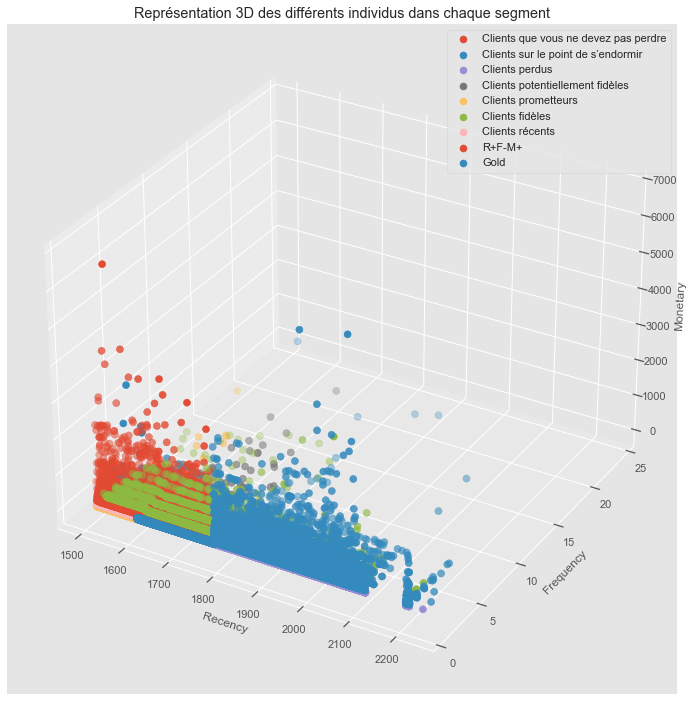

In [84]:
#def projection_3d_segments(rfm_table, label_score, colors) :   
fig = plt.figure(1, figsize=(12, 18))
ax = fig.add_subplot(111, projection='3d')
    # Pour chaque segment, scatter plot des individus avec code couleur
for Group_label in rfm_table_3['Group_label'].unique():
    ax.scatter(rfm_table_3[rfm_table_3['Group_label'] == Group_label].recency,
                   rfm_table_3[rfm_table_3['Group_label'] == Group_label].frequency,
                   rfm_table_3[rfm_table_3['Group_label'] == Group_label].price_mean,
                   label=Group_label,
                   s=50)
    # Titre des axes et titre graphique
    ax.set_xlabel("Recency")
    ax.set_ylabel("Frequency")
    ax.set_zlabel("Monetary")
    plt.title("Représentation 3D des différents individus dans chaque segment")

    plt.legend()
plt.show()

In [85]:
rfm_table_3['Group_label'].unique().tolist()

['Clients que vous ne devez pas perdre',
 'Clients sur le point de s’endormir',
 'Clients perdus',
 'Clients potentiellement fidèles',
 'Clients prometteurs',
 'Clients fidèles',
 'Clients récents',
 'R+F-M+',
 'Gold']

In [99]:
cluster_count = rfm_table_3.groupby(by='Group_label')['Group_label'].count()

In [101]:
cluster_count.index

Index(['Clients fidèles', 'Clients perdus', 'Clients potentiellement fidèles',
       'Clients prometteurs', 'Clients que vous ne devez pas perdre',
       'Clients récents', 'Clients sur le point de s’endormir', 'Gold'],
      dtype='object', name='Group_label')

In [ ]:
fig = plt.figure(figsize = (22, 8))
gs = fig.add_gridspec(1,3)
ax = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[0,2])


for Group_label in rfm_table_3['Group_label'].unique().tolist():
        
        ax.scatter(rfm_table_3[rfm_table_3['Group_label'] == Group_label].recency, \
                   rfm_table_3[rfm_table_3['Group_label'] == Group_label].frequency, label=Group_label)
        
        #ax.lines[0].set_color('green')
        ax.set_xlabel('recency')
        ax.set_ylabel("frequency")
        #ax.set_title('Histogramme de la variable'+ col )
        ax1.scatter(rfm_table_3[rfm_table_3['Group_label'] == Group_label].recency, \
                   rfm_table_3[rfm_table_3['Group_label'] == Group_label].price_mean, label=Group_label)
        ax1.set_xlabel('recency')
        ax1.set_ylabel("price_mean")
        
        ax2.scatter(rfm_table_3[rfm_table_3['Group_label'] == Group_label].price_mean, \
                   rfm_table_3[rfm_table_3['Group_label'] == Group_label].frequency, label=Group_label)
        ax2.set_xlabel('price_mean')
        ax2.set_ylabel("frequency")
        ax2.legend()
        

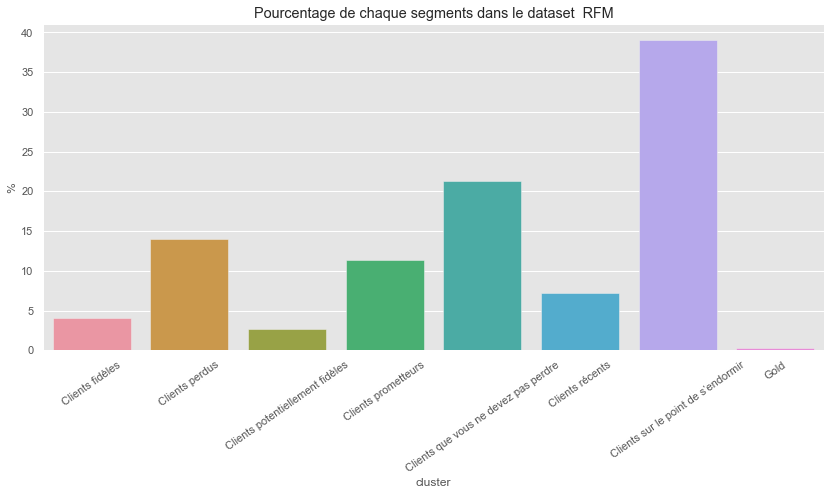

In [139]:
def missing_data(df):
    cluster_count = df.groupby(by='Group_label')['Group_label'].count()/len(df)*100

    # Affiche la proportion de données manquants par colonne
    fig = plt.figure(figsize=(14, 6))
    sns.barplot(x=cluster_count.index, y=cluster_count.values)
    plt.ylabel("%")
    plt.xlabel("cluster", )
    plt.title("Pourcentage de chaque segments dans le dataset  RFM")
    plt.style.use('ggplot')
    plt.xticks(rotation=35)
    plt.show()
    return plt.show()
missing_data(df = data_rfm )

In [ ]:
liste = ['price_mean', 'frequency','recency']
for liste in liste:
    groupe = data_rfm[liste, 'Group_label']

<Figure size 864x288 with 0 Axes>

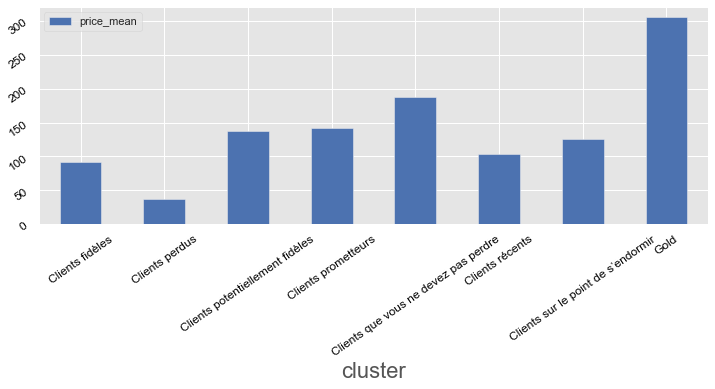

<Figure size 864x288 with 0 Axes>

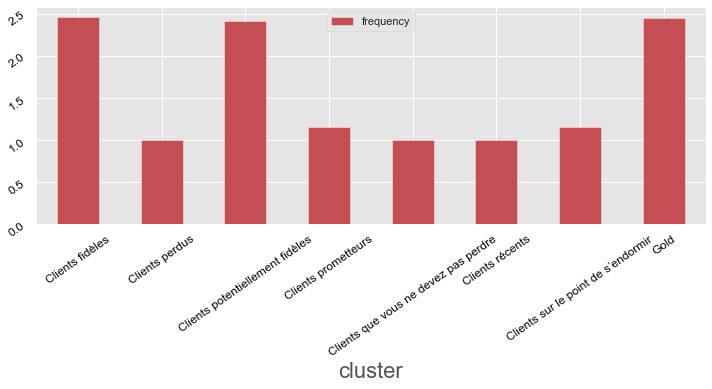

<Figure size 864x288 with 0 Axes>

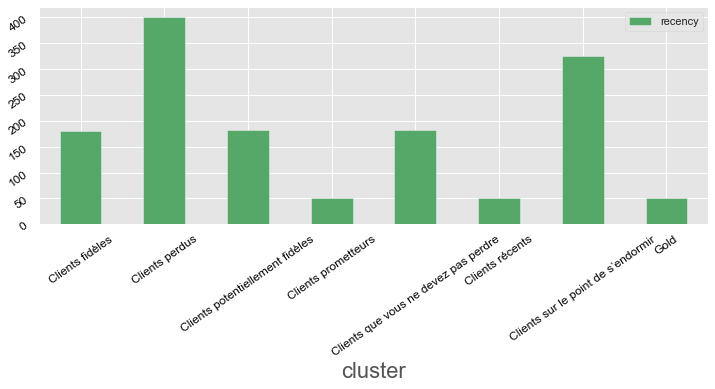

In [149]:
liste = ['price_mean', 'frequency','recency']
for liste in liste:
    groupe = data_rfm[[liste, 'Group_label']].groupby(by='Group_label').mean()
    ax = plt.figure(figsize=(12,4))
    if liste == 'price_mean':
        c = 'b'
    elif liste == 'frequency':
        c = 'r'
    else:
        c = 'g'
    ax = abs(groupe).plot.bar(figsize=(12,4), color = c);
    plt.xticks(rotation=35, fontsize=12, color='black')
    plt.xlabel("cluster", fontsize=22)
    plt.yticks(rotation=35, fontsize=12, color='black')
    ax.legend()
    plt.show()
    #display(df)

### Création du datatset_client

In [171]:
data_customers = data_customers.groupby("customer_unique_id")\
            .agg({"price": "sum", 'credit_card': "sum", 'boleto': "sum", 'debit_card': "sum", 'review_score': 'mean',
                  
                  'voucher': "sum",
                  
                  'review_comment_title': "sum", 'review_comment_message': "sum",
                  'geolocation_lat': 'mean', 'geolocation_lng':'mean', 
                   
                  'payment_sequential': 'mean', 'payment_installments': 'max', 'Delay_to_answer': 'max', 
                  
                  'delivery_delta_days': 'max', 'estimated_delivery_delta_days': 'max', 'freight_value': 'mean',
                  'payment_value':'mean', 'order_purchase_timestamp':  'max',
                  
                  'customer_city' : lambda x: x.mode()[0],
                   'customer_state' : lambda x: x.mode()[0],
                  
                  
            })
data_customers.rename({"price": "price_sum", 'credit_card': 'Nb_payement_credit_card', 
                 'boleto': 'Nb_payement_boleto', 'debit_card': 'Nb_payement_debit_card',
                 'voucher': 'Nb_payement_voucher' , 'credit_card': 'Nb_payement_credit_card',
                 'review_score': 'review_score_mean', 'review_comment_title': 'review_comment_title_sum',
                 
                 'payment_sequential':'payment_sequential_mean', 'payment_installments': 'payment_installments_max',
                 'Delay_to_answer': 'Delay_to_answer_max', 'delivery_delta_days':'delivery_delta_days_max', 
                 'estimated_delivery_delta_days': 'estimated_delivery_delta_days_max', 'freight_value':'freight_value_mean',
                 'payment_value': 'payment_value_mean'}, axis = 1, inplace = True
                 
                 
                 
                )

In [75]:
data_customers.columns

Index(['price_sum', 'Nb_payement_credit_card', 'Nb_payement_boleto', 'Nb_payement_debit_card', 'review_score_mean', 'Nb_payement_voucher', 'review_comment_title_sum', 'review_comment_message', 'geolocation_lat', 'geolocation_lng', 'payment_sequential_mean', 'payment_installments_max', 'Delay_to_answer_max', 'delivery_delta_days_max', 'estimated_delivery_delta_days_max', 'freight_value_mean', 'payment_value_mean', 'order_purchase_timestamp', 'customer_city', 'customer_state'], dtype='object')

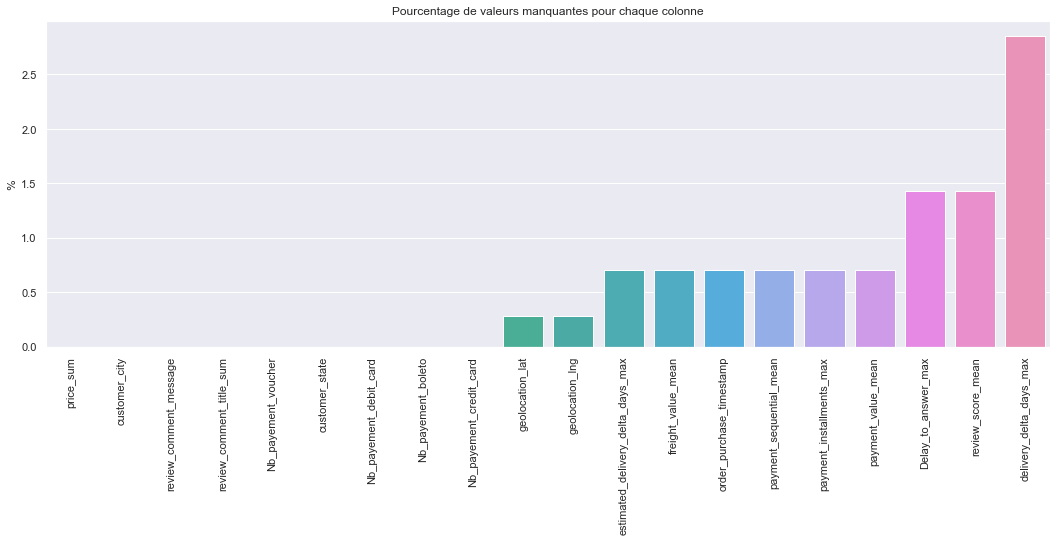

In [76]:
# Calcul des valeurs manquantes
null_prop = data_customers.isna().sum(axis=0).sort_values()/len(data_test)*100

# Affiche la proportion de données manquants par colonne
fig = plt.figure(figsize=(18, 6))
sns.barplot(x=null_prop.index, y=null_prop.values)
plt.ylabel("%")
plt.title("Pourcentage de valeurs manquantes pour chaque colonne")
plt.style.use('ggplot')
plt.xticks(rotation=90)
plt.show()

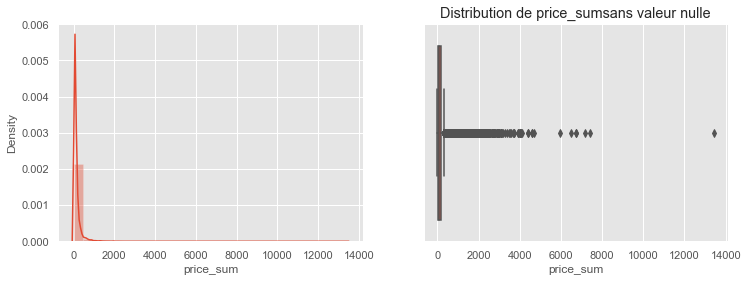

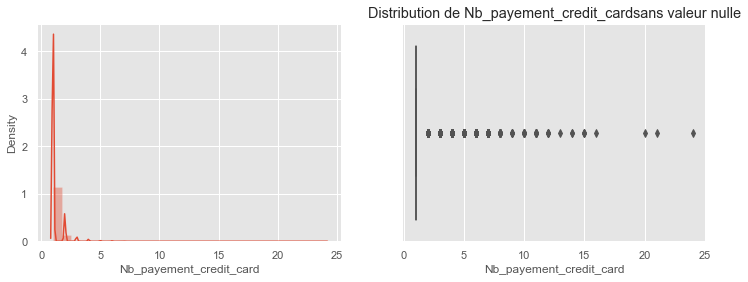

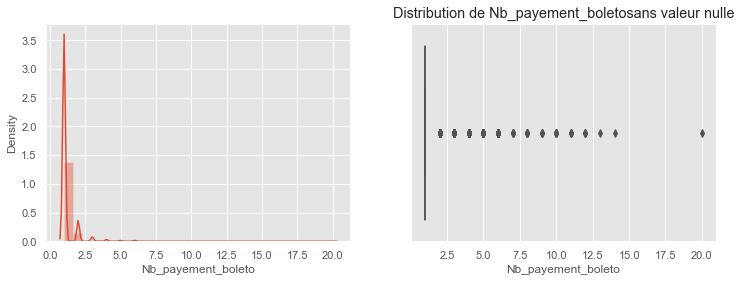

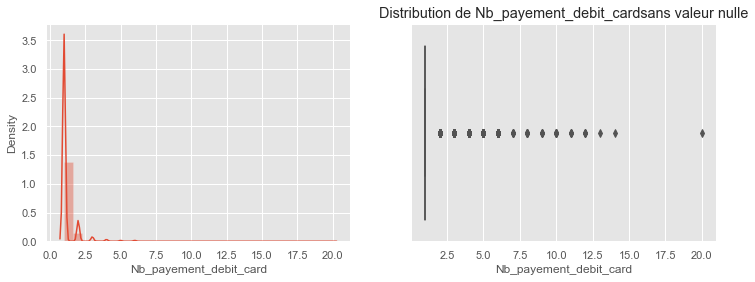

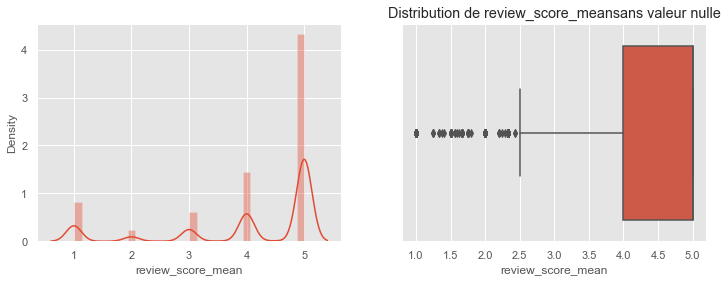

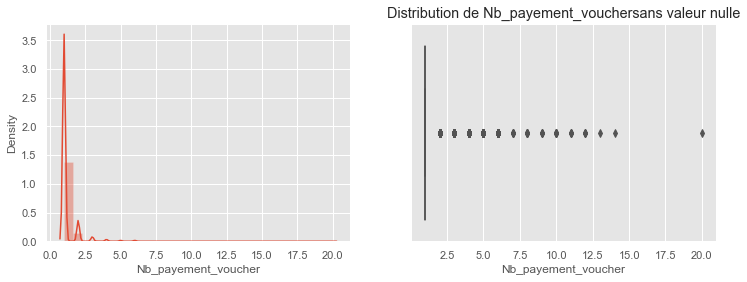

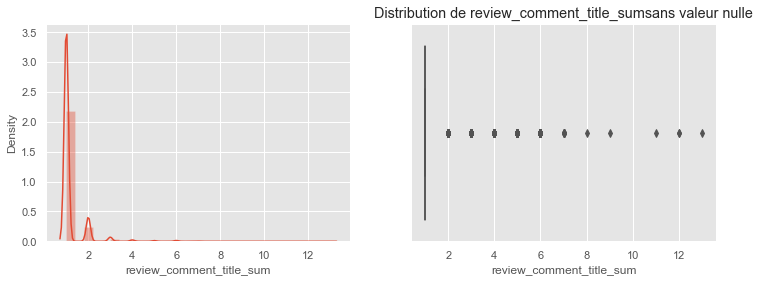

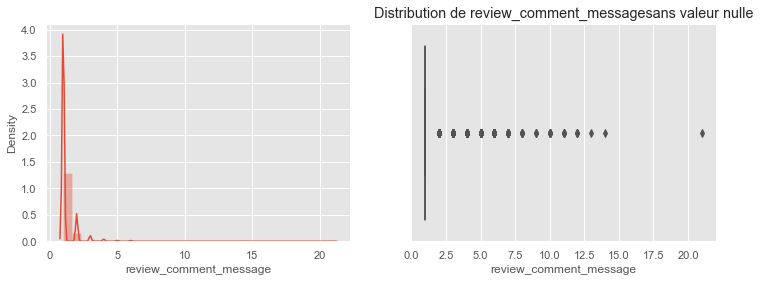

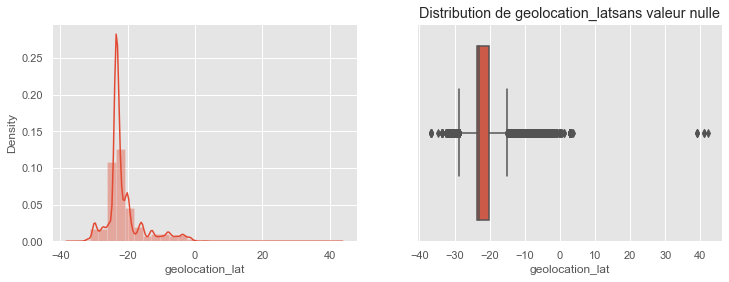

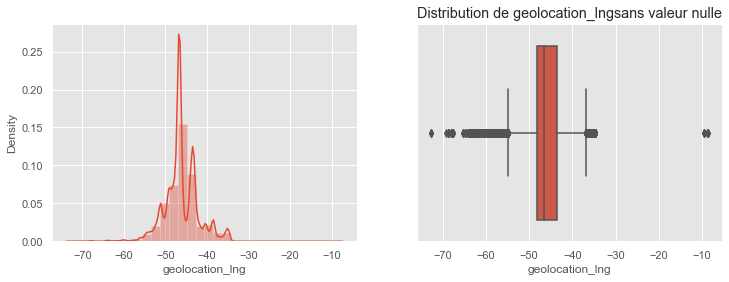

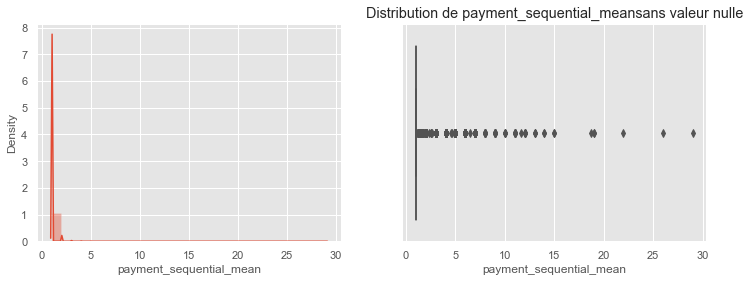

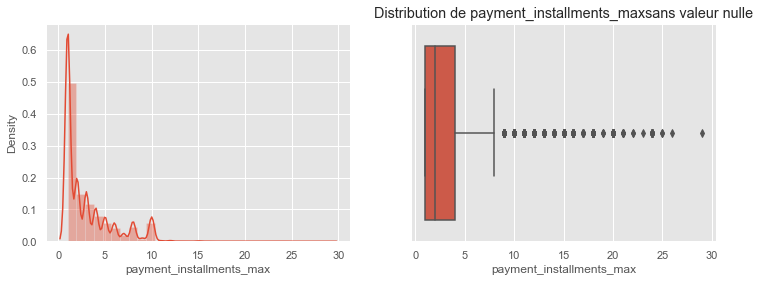

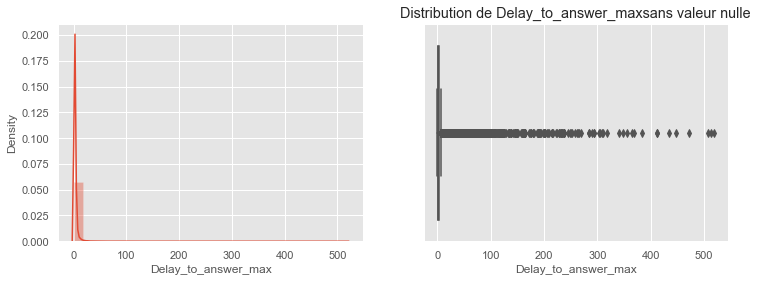

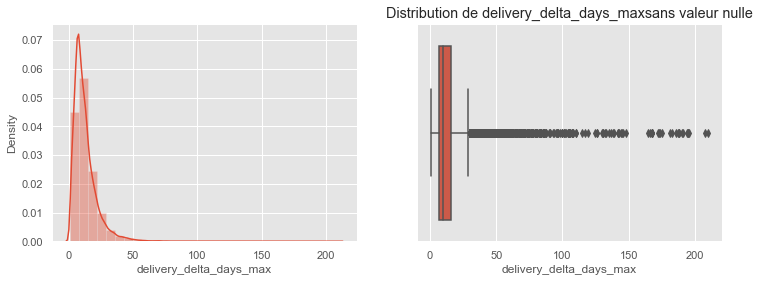

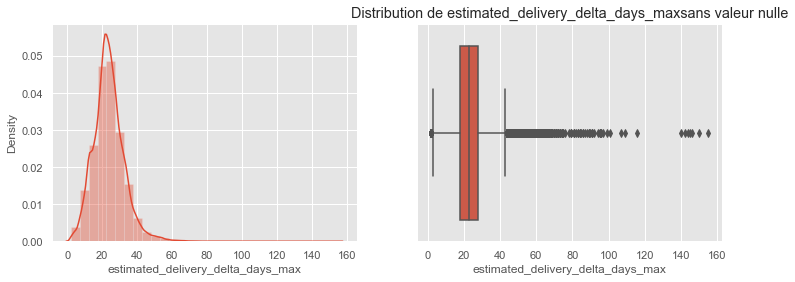

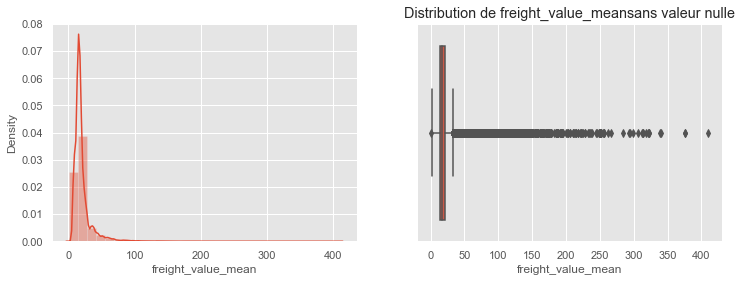

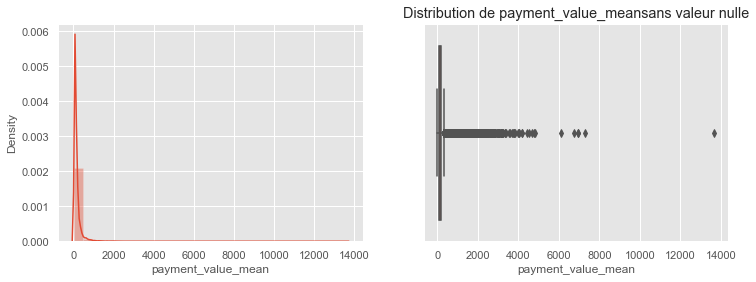

In [78]:
for column in data_customers.select_dtypes(['int32', 'float64']).columns:
    f, axes = plt.subplots(1,2, figsize=(12,4))
    titre = 'Distribution de ' + str(column) +' sans valeur nulle'
    plt.title(titre)
    sns.distplot(data_test[data_test[column] != 0][column], bins=30, ax=axes[0])
    titre = 'Distribution de ' + str(column) +'sans valeur nulle'
    plt.title(titre)
    sns.boxplot(data_test[data_test[column] != 0][column], ax=axes[1])
    plt.show()

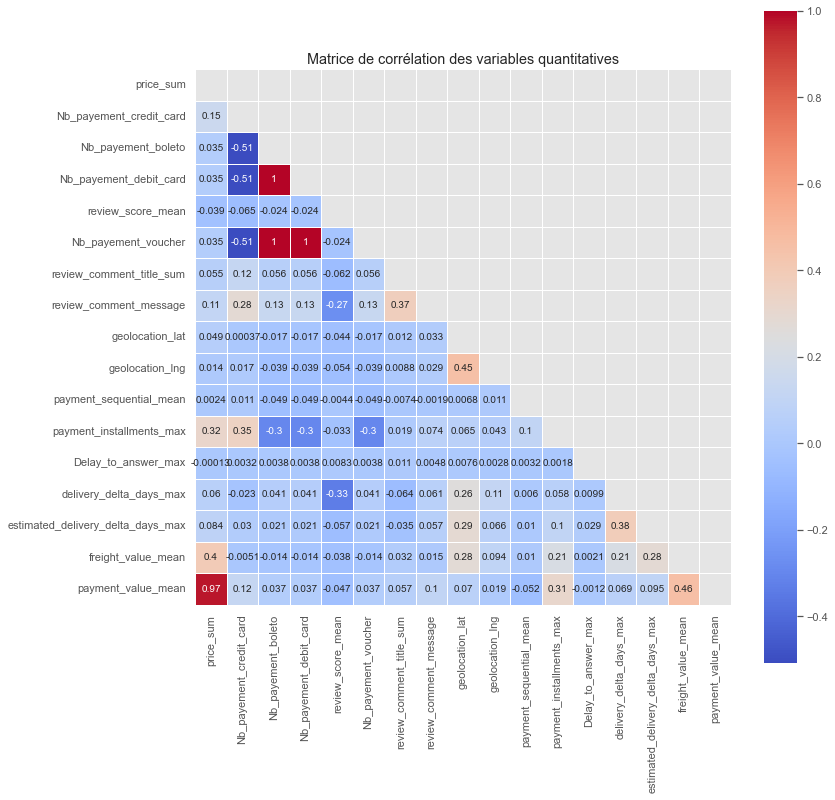

In [121]:
corr_matrix = data_test.select_dtypes(include = ['int', 'float']).corr()
mask = np.triu(corr_matrix)
plt.figure(figsize=(12,12))
sns.heatmap(corr_matrix, cmap="coolwarm", mask=mask, linewidths=.5, annot=True, cbar=True, square=True)
plt.title("Matrice de corrélation des variables quantitatives")
#plt.savefig("Présentation/Images/matrice_corr.png")
plt.show()

In [172]:
data_customers.to_csv('/Users/admin/Desktop/formation_data_Scientist/projet5/Donnees/data_customers', index=True)

In [173]:
data_rfm.to_csv('/Users/admin/Desktop/formation_data_Scientist/projet5/Donnees/data_rfm', index=True)